In [162]:

import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
     

In [163]:
import torch

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using:", device)

Using: mps


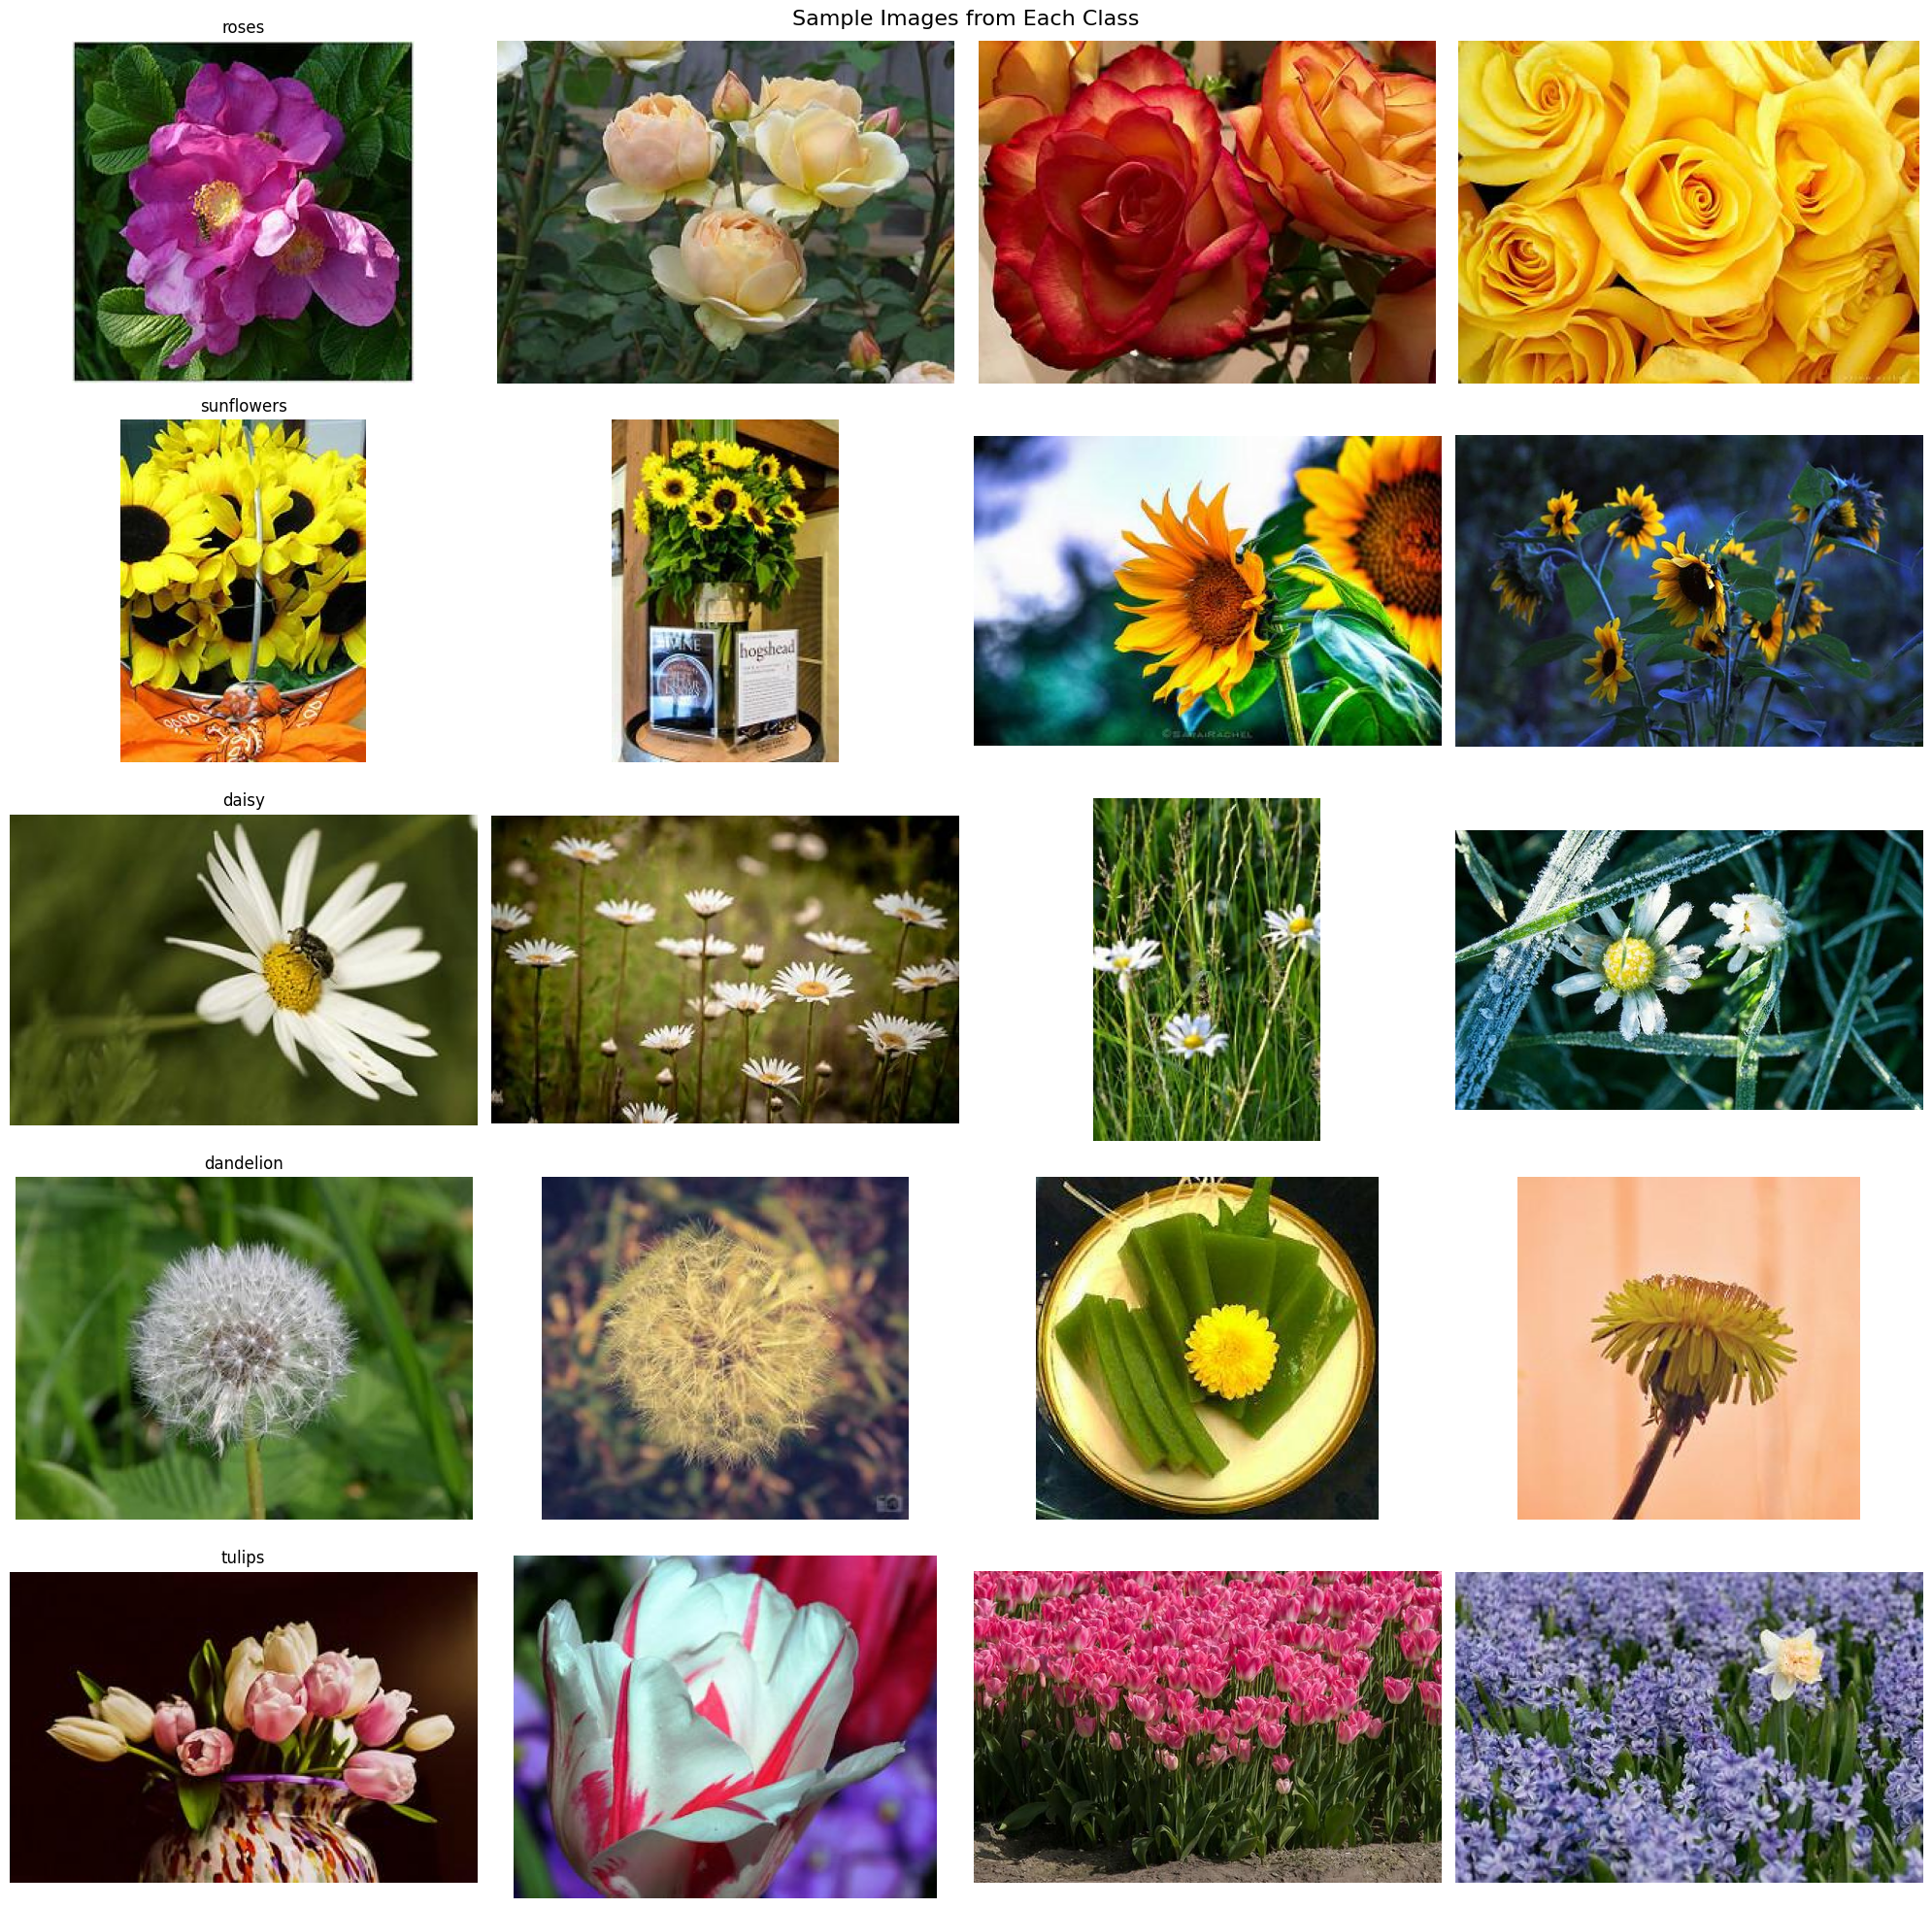

Original dataset shape: (3670, 2)
Train size: 2936
Val size: 367
Test size: 367

Class distribution:
Original:
label
dandelion     0.244687
tulips        0.217711
sunflowers    0.190463
roses         0.174659
daisy         0.172480
Name: proportion, dtype: float64

Train:
label
dandelion     0.244550
tulips        0.217643
sunflowers    0.190395
roses         0.174728
daisy         0.172684
Name: proportion, dtype: float64

Test:
label
dandelion     0.245232
tulips        0.217984
sunflowers    0.190736
roses         0.174387
daisy         0.171662
Name: proportion, dtype: float64


In [204]:
image_path_list = []
label_list = []

for class_cat in os.listdir("tf_flowers_images"):
    if class_cat.startswith("."):   # ignore system files
        continue
    for image_object in os.listdir(f"tf_flowers_images/{class_cat}"):
        if image_object.startswith("."):
            continue
        image_path_list.append(f"tf_flowers_images/{class_cat}/{image_object}")
        label_list.append(class_cat)
df = pd.DataFrame()

df["image_path"] = image_path_list
df["label"] = label_list

df


# Get unique classes
classes = df['label'].unique()

# Number of images to display per class
n_images = 4

# Set up the plot
fig, axes = plt.subplots(len(classes), n_images, figsize=(20, 4*len(classes)))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for i, class_name in enumerate(classes):
    # Filter dataframe for current class
    class_df = df[df['label'] == class_name]

    # Randomly sample n_images from this class
    sample_images = class_df['image_path'].sample(n_images).tolist()

    for j, img_path in enumerate(sample_images):
        # Open and display the image
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

        # Set the title for the first image in each row
        if j == 0:
            axes[i, j].set_title(f'{class_name}', fontsize=12)

plt.tight_layout()
plt.show()

# %%
test_ratio = 0.10 # 20% of data will go to test

# split the data
train_val_df, test_df = train_test_split(
    df, test_size=0.10, stratify=df['label'], random_state=42
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.111, stratify=train_val_df['label'], random_state=42
)

print(f"Original dataset shape: {df.shape}")
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


# Print class distribution
print("\nClass distribution:")
print("Original:")
print(df['label'].value_counts(normalize=True))
print("\nTrain:")
print(train_df['label'].value_counts(normalize=True))
print("\nTest:")
print(test_df['label'].value_counts(normalize=True))

# %%
IMAGE_SIZE = 128

# this will be used during training, this will hold all the augmentation/transformation configs
training_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                             transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# this will be used during testing / infernece, wo don't want any kind of additional transformation applied at the time of running model prediction in test / production inviroment
test_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                             transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
TRANSFORMS = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.7,1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
])
     

# %%
# list of classes in your dataset
CLASS_LIST = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [205]:
# Define custom Dataset -> this will help you load images from your csv file
class CustomTrainingData(Dataset):
    def __init__(self, csv_df, class_list, transform=None):
        self.df = csv_df
        self.transform = transform
        self.class_list = class_list

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        image = Image.open(self.df.iloc[index].image_path).convert('RGB')
        label = self.class_list.index(self.df.iloc[index].label)

        if self.transform:
            image = self.transform(image)

        return image, label


# create data object
train_data_object = CustomTrainingData(train_df, CLASS_LIST, TRANSFORMS)
test_data_object = CustomTrainingData(test_df, CLASS_LIST, TRANSFORMS)
val_dataset = CustomTrainingData(val_df, CLASS_LIST, TRANSFORMS)

# %%
BATCH_SIZE = 32

# now define dataloader, this will load the images batches from CustomTrainingData object
train_loader = DataLoader(train_data_object, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data_object, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [206]:
class SatelliteImageClassifier(nn.Module):
    def __init__(self, num_classes, input_size=(IMAGE_SIZE, IMAGE_SIZE), channels=3):
        super(SatelliteImageClassifier, self).__init__()

        self.input_size = input_size
        self.channels = channels

        # Convolutional layers
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Calculate the size of the flattened features
        self._to_linear = None
        self._calculate_to_linear(input_size)

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _calculate_to_linear(self, input_size):
        # This function calculates the size of the flattened features
        x = torch.randn(1, self.channels, *input_size)
        self.conv_forward(x)

    def conv_forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.conv_forward(x)

        # Flatten the output for the fully connected layer
        # x = x.view(-1, self._to_linear)
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x
     

In [207]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.001
NUM_CLASSES = len(CLASS_LIST)
INPUT_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
CHANNELS = 3

# %%
# Initialize the model
model = SatelliteImageClassifier(NUM_CLASSES, INPUT_SIZE, CHANNELS).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
# %%
# Print model summary
print(model)

# If you want to see the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Test with a random input
test_input = torch.randn(1, CHANNELS, *INPUT_SIZE).to(device)
output = model(test_input)
print(f"Output shape: {output.shape}")

SatelliteImageClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)
Total number of parameters: 8781061
Output shape: to

In [ ]:
# Storage for plotting
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}
# Training loop
best_loss = float('inf')
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct_train / total_train
    
    # --- VALIDATION ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val
    
    # Store history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f} | Val Loss {avg_val_loss:.4f} | Val Acc {val_acc:.4f}")

    # (Optional) Scheduler Step
    # scheduler.step(avg_val_loss)
    

Epoch 1: Train Loss 2.1841 | Val Loss 1.1933 | Val Acc 0.4469
Epoch 2: Train Loss 1.1093 | Val Loss 1.0988 | Val Acc 0.5368
Epoch 3: Train Loss 1.0213 | Val Loss 1.0714 | Val Acc 0.5613
Epoch 4: Train Loss 0.9821 | Val Loss 0.9868 | Val Acc 0.5913
Epoch 5: Train Loss 0.9157 | Val Loss 0.9744 | Val Acc 0.5967
Epoch 6: Train Loss 0.8924 | Val Loss 0.9872 | Val Acc 0.5858
Epoch 7: Train Loss 0.8915 | Val Loss 0.9172 | Val Acc 0.6458
Epoch 8: Train Loss 0.8495 | Val Loss 0.9673 | Val Acc 0.6185
Epoch 9: Train Loss 0.7984 | Val Loss 0.9110 | Val Acc 0.6540
Epoch 10: Train Loss 0.8065 | Val Loss 0.9200 | Val Acc 0.6485
Epoch 11: Train Loss 0.7685 | Val Loss 0.9818 | Val Acc 0.6213
Epoch 12: Train Loss 0.7642 | Val Loss 0.9187 | Val Acc 0.6730
Epoch 13: Train Loss 0.7537 | Val Loss 0.9041 | Val Acc 0.6567
Epoch 14: Train Loss 0.7587 | Val Loss 0.9800 | Val Acc 0.6621
Epoch 15: Train Loss 0.7349 | Val Loss 0.9149 | Val Acc 0.6540
Epoch 16: Train Loss 0.7258 | Val Loss 0.9259 | Val Acc 0.6757
E

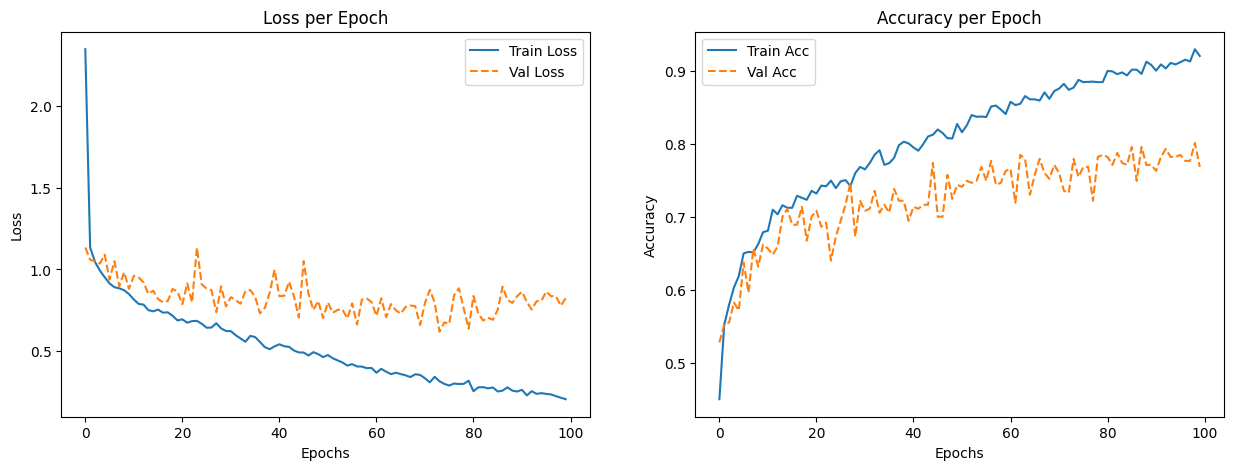

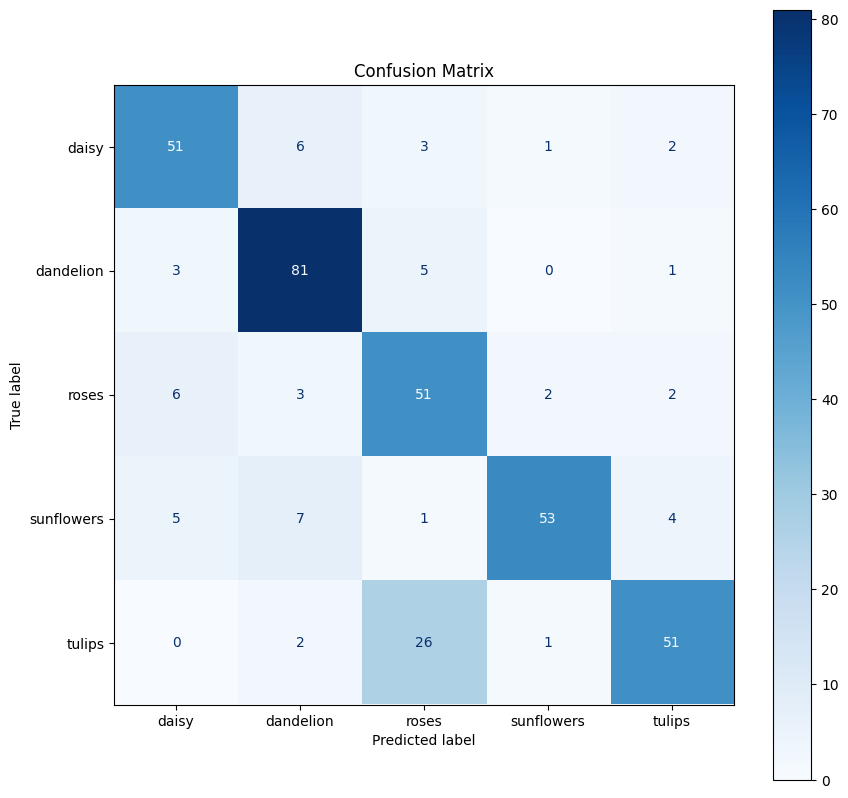

In [202]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# 1. Plot Loss and Accuracy
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Loss Plot
ax[0].plot(history['train_loss'], label='Train Loss')
ax[0].plot(history['val_loss'], label='Val Loss', linestyle='--')
ax[0].set_title('Loss per Epoch')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Accuracy Plot
ax[1].plot(history['train_acc'], label='Train Acc')
ax[1].plot(history['val_acc'], label='Val Acc', linestyle='--')
ax[1].set_title('Accuracy per Epoch')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

# 2. Confusion Matrix (on Validation or Test Set)
# We use the best model state here ideally
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader: # Or test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.show()

In [203]:
model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():  # Save memory, don't calculate gradients
    for images, labels in test_loader:  # Use test_loader here!
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Move to CPU and convert to numpy for sklearn
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# 4. Calculate Macro F1
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f'Final Test Set Macro F1 Score: {macro_f1:.4f}')

Final Test Set Macro F1 Score: 0.8050


200 epochs 10% lr = 0.0001 : Macro F1 Score: 0.8312271379875874
200 epochs 10% lr = 0.001 : Macro F1 Score: 0.8664668836956941
Macro F1 Score: 0.84710148798746 - dropout 0.3 cu val
400 epochs 10% lr = 0.0001 : Macro F1 Score: 0.828059127851874
Macro F1 Score: 0.8385280076260468
400 epochs 10% lr ajustat : Macro F1 Score: 0.8873027795670148
Macro F1 Score: 0.8583729851629032
200 epochs 10% lr ajustat size 180 :Macro F1 Score: 0.8630956021495741
200 epochs 10% lr ajustat 0.3 dropout : Macro F1 Score: 0.8709166107757657
Macro F1 Score: 0.8203011101549882
200 epochs 10% lr ajustat 0.5 dropout : Macro F1 Score: 0.8662953277294475
Macro F1 Score: 0.8481924654599267
Macro F1 Score: 0.859452754604243